In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import glob
import sys
from collections import OrderedDict

import csv

In [2]:
def check_overlap(interval, array):
    height = array.shape[0]
    intervals = np.stack([np.tile(interval,(height,1)), array],axis=0)
    anchor =  (intervals[0,:,0] < intervals[1,:,0]).astype(int)
    return intervals[1-anchor,np.arange(height),1] > intervals[anchor,np.arange(height),0]


In [3]:
G1R1_fn = '../data/GATA1_rep5detailed.txt'
G1R2_fn = '../data/GATA1_rep7detailed.txt'

H6R1_fn = '../data/HDAC_rep9detailed.txt'
H6R2_fn = '../data/HDAC_rep10detailed.txt'

ABC1_fn = '../data/FULCO__GATA1_rep1_10p.txt'
ABC2_fn = '../data/FULCO__GATA1_rep2_10p.txt'
ABC3_fn = '../data/FULCO__GATA1_rep3_10p.txt'

FULC_fn = '../data/Join_PanGATA__GATA_CRISPRI_growth___GUIDESCAN_annotated.txt'

fn_list = [G1R1_fn,G1R2_fn,H6R1_fn,H6R2_fn,ABC1_fn,ABC2_fn,ABC3_fn]

exp_ids = ['G1R1','G1R2','H6R1','H6R2','ABC1','ABC2','ABC3','FUL1','FUL2']

fullinfo= [("GATA1",1), ("GATA1",2), ("HDAC6",1), ("HDAC6",2), 
           ("ABC",1), ("ABC",2), ("ABC",3), ("Fulco",1), ("Fulco",2)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['Ref1'] = ('Growth paper', 1)
id2info['Ref2'] = ('ABC paper', 1)
id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

In [4]:
gff = pd.read_table('../data/GATA_locus.gff')

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [5]:
gff

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,proteinID,transcriptID,geneID
0,ENST00000376670.8,chrX,+,48786553,48794311,48791109,48794164,6,"48786553,48791090,48791843,48792322,48793171,4...","48786645,48791329,48792221,48792468,48793297,4...",P15976,ENST00000376670.8,GATA1
1,ENST00000376619.6,chrX,+,48802033,48824976,48802692,48824612,29,"48802033,48802662,48802870,48803127,48805437,4...","48802170,48802785,48802999,48803216,48805522,4...",Q9UBN7,ENST00000376619.6,HDAC6


In [6]:
data = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )
    print(d_pt.shape)


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(15339, 8)
(15339, 8)
(15339, 8)
(15339, 8)
(11780, 4)
(11511, 4)
(11850, 4)


In [7]:
data = pd.concat([ df.drop_duplicates(subset='Coordinates', keep='first').set_index('Coordinates') for df in data ],axis=1,join='outer',sort=False)

In [8]:
# Flip ABC data
data['ABC1'] = data['ABC1'] * -1
data['ABC2'] = data['ABC2'] * -1
data['ABC3'] = data['ABC3'] * -1

### Append Fulco Growth data

In [9]:
fulc = pd.read_table(FULC_fn, sep='\t', header=0)
fulc = fulc.loc[ fulc.loc[:,'FulcoCRISPRiGrowth_exo'] == 'FulcoCRISPRiGrowth', 
                 ('Fulco_CRISPRi_Growth_coords', 'Fulco_CRISPRi Score (rep1)', 'Fulco_CRISPRi Score (rep2)') ]
fulc.columns = ["Coordinates","FUL1","FUL2"]
fulc = fulc.set_index("Coordinates")
fulc = fulc.astype(float)
fulc['FUL1'] = fulc['FUL1'] * -1
fulc['FUL2'] = fulc['FUL2'] * -1

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [10]:
data = pd.concat([data, fulc], axis=1, sort=False)

In [11]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

In [12]:
test_peaks = [ pd.read_table(fn,sep='\t',header=None,usecols=[0,1,2],names=['chr','start','end']) for fn in ['../data/GATA1_rep5__mergedPeaks.bed','../data/GATA1_rep7__mergedPeaks.bed'] + ['../data/HDAC_rep9__mergedPeaks.bed','../data/HDAC_rep10__mergedPeaks.bed'] + ['../data/ABC_rep1__sigPeaks.bed','../data/ABC_rep2__sigPeaks.bed','../data/ABC_rep3__sigPeaks.bed'] + ['../data/Fulco_GATA_enhancer_filter.bed','../data/Fulco_GATA_enhancer_filter.bed'] ]
print(len(test_peaks))
extra_feat = [ pd.read_table(fn,sep='\t',header=None,names=['chr','start','end'],usecols=[0,1,2]) for fn in ['../data/Fulco_GATA_enhancer_filter.bed','../data/ABC_paperPeaks_hg38.bed','../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed','../data/DNASE_peaks_replicated.bed'] ]
[ test_peaks.append( feat.loc[ feat['chr'] == 'chrX' ,:] ) for feat in extra_feat ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print(len(test_peaks))
for exp_id, peaks_idx in zip(['G1R1','G1R2','H6R1','H6R2','ABC1','ABC2','ABC3','FUL1','FUL2','Ref1','Ref2','k27','DHS'],range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


9
13


In [13]:
test_peaks = pd.concat([test_peaks,
                        pd.DataFrame([pd.Series(OrderedDict([('chr','chrX'),('start',0),('end',1),('exp_id','FUL1'),('assay','Fulco'),('replicate',1)])),
                                      pd.Series(OrderedDict([('chr','chrX'),('start',0),('end',1),('exp_id','FUL2'),('assay','Fulco'),('replicate',2)]))])
                       ],axis=0,ignore_index=True)


In [14]:
def plot_hff_cutsites(plot_interval, cutsite_data, peak_data, plot_ids):
    # Subset cutsite scores
    plot_id_slicer = [an_id for an_id in plot_ids if an_id in cutsite_data.columns]
    sub_cuts = cutsite_data.loc[:,plot_id_slicer]
    sub_cuts['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                            if coord.split(':')[-1] == '+' 
                            else 
                            int(coord.split(':')[1].split('-')[0]) + 3 
                            for coord in sub_cuts.index ]
    slice_cuts = check_overlap(plot_interval,np.vstack([cutsite_data['cutsite'].values, 
                                                       (cutsite_data['cutsite']+1).values]).T)
    sub_cuts = sub_cuts.loc[slice_cuts, :]
    # Subset peak intervals
    sub_peaks= check_overlap(plot_interval, peak_data.loc[:,('start','end')].values)
    sub_peaks= peak_data.loc[sub_peaks,:]
    sub_peaks= sub_peaks.loc[ sub_peaks['exp_id'].isin(plot_ids) ]
    
    cut_types  = np.unique(sub_cuts.columns)
    peak_types = np.unique(sub_peaks['exp_id'])
    
    col_dict = { exp_id: color
                 for exp_id, color 
                 in zip(plot_ids, 
                        plt.rcParams['axes.prop_cycle'] \
                          .by_key()['color'][:len(plot_ids)]
                       )
               }

    score_max = np.nanmax(sub_cuts.loc[:, plot_id_slicer].values)
    score_min = np.nanmin(sub_cuts.loc[:, plot_id_slicer].values)
    score_gap = score_max - \
                score_min
    fig = plt.figure(figsize=(12,6))
    ax  = plt.subplot(111)
    for i, exp_id in enumerate(col_dict.keys()):
        sub_sub_peaks = sub_peaks.loc[ sub_peaks['exp_id'] == exp_id, : ]
        peak_position = score_max + ( ( 0.2+(i*0.05) ) * score_gap )
        for j, row in sub_sub_peaks.iterrows():
            ax.hlines(y=peak_position, 
                      xmin=row['start'], xmax=row['end'],
                      color=col_dict[exp_id])
        if exp_id in cut_types:
            null_filter = sub_cuts[exp_id].isnull()
            ax.scatter(sub_cuts.loc[~null_filter,'cutsite'].values,
                       sub_cuts.loc[~null_filter,exp_id].values,
                       color=col_dict[exp_id],s=8,alpha=0.5)
            
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(*plot_interval)
    custom_lines = [ Line2D([0], [0], color=col_dict[color]) for color in plot_ids ]
    ax.legend(custom_lines, plot_ids,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    return fig, ax
            

In [15]:
def _draw_genes_from_gff(ax, gff, promoter_params=[1000,0.2,1000]):
    for i, line in gff.iterrows():
        exonStarts = [int(x) for x in line['exonStarts'].split(',')]
        exonEnds   = [int(x) for x in line['exonEnds'].split(',')]
        direction  = 2*int(line['strand'] == '+') - 1
        for start, end in zip(exonStarts, exonEnds):
            ax.fill_betweenx([-7.0,-5.0],[start,start],[end,end],facecolor='black')
        ax.hlines(y=-6.0,xmin=exonStarts[0],xmax=exonEnds[-1])
        if direction == 1:
            x_loc = exonStarts[0]
        else:
            x_loc = exonEnds[-1]
        ax.vlines(x=x_loc,ymin=-5.0,ymax=-4.5)
        #ax.annotate("", xy=(x_loc+(direction*2000), 1.0), xytext=(x_loc, 1.0),arrowprops=dict(arrowstyle="->"))
        ax.arrow(x=x_loc,y=-4.5,dx=direction*promoter_params[0],dy=0, 
                 head_width=promoter_params[1], head_length=promoter_params[2], fc='k', ec='k')
    return None


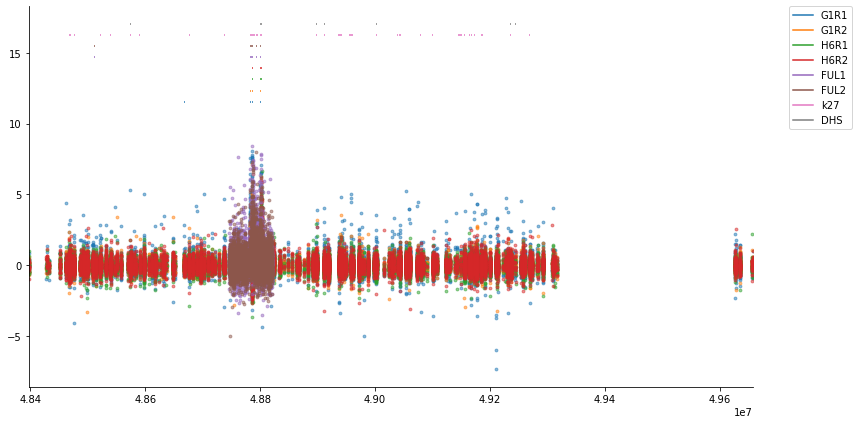

In [16]:
fig_h, ax_h = plot_hff_cutsites(np.array([[48397729,49657309]]), 
          data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])


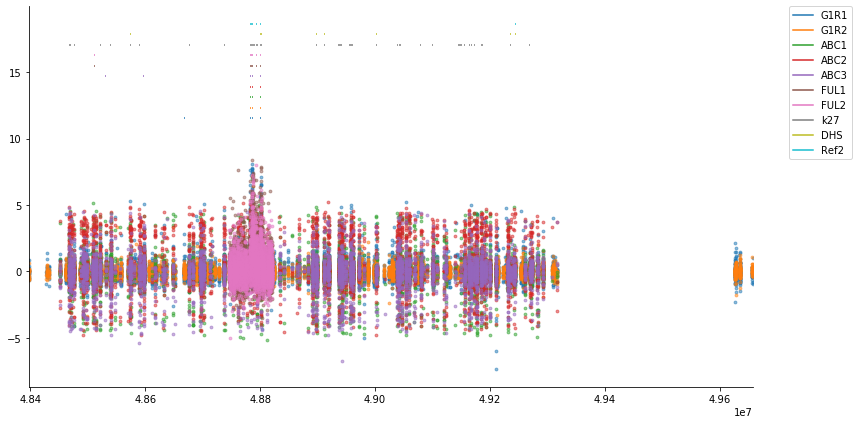

In [17]:
fig_h, ax_h = plot_hff_cutsites(np.array([[48397729,49657309]]), 
          data, test_peaks, plot_ids=['G1R1','G1R2','ABC1','ABC2','ABC3','FUL1','FUL2','k27','DHS','Ref2'])


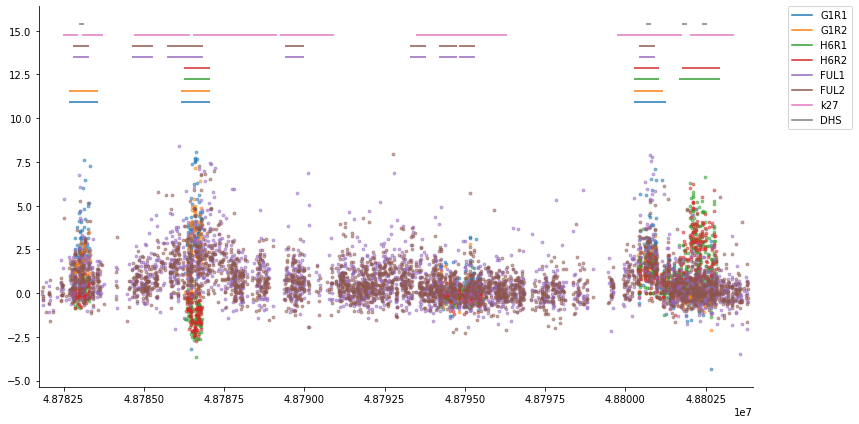

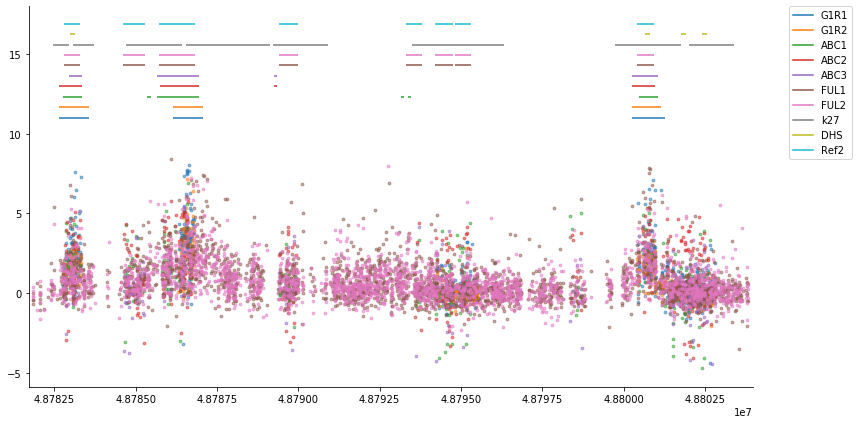

In [18]:
fig_h, ax_h = plot_hff_cutsites(np.array([[48781722,48803966]]), 
          data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])

fig_h, ax_h = plot_hff_cutsites(np.array([[48781722,48803966]]), 
          data, test_peaks, plot_ids=['G1R1','G1R2','ABC1','ABC2','ABC3','FUL1','FUL2','k27','DHS','Ref2'])


In [19]:
def plot_combined_cutsites(plot_interval, cutsite_data, peak_data, plot_ids):
    # Subset cutsite scores
    plot_id_slicer = [an_id for an_id in plot_ids if an_id in cutsite_data.columns]
    sub_cuts = cutsite_data.loc[:,plot_id_slicer]
    sub_cuts['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                            if coord.split(':')[-1] == '+' 
                            else 
                            int(coord.split(':')[1].split('-')[0]) + 3 
                            for coord in sub_cuts.index ]
    slice_cuts = check_overlap(plot_interval,np.vstack([cutsite_data['cutsite'].values, 
                                                       (cutsite_data['cutsite']+1).values]).T)
    sub_cuts = sub_cuts.loc[slice_cuts, :]
    # Subset peak intervals
    sub_peaks= check_overlap(plot_interval, peak_data.loc[:,('start','end')].values)
    sub_peaks= peak_data.loc[sub_peaks,:]
    sub_peaks= sub_peaks.loc[ sub_peaks['exp_id'].isin(plot_ids) ]
    
    cut_types  = np.unique(sub_cuts.columns)
    peak_types = np.unique(sub_peaks['exp_id'])
    
    score_max = np.nanmax(sub_cuts.loc[:, plot_id_slicer].values)
    score_min = np.nanmin(sub_cuts.loc[:, plot_id_slicer].values)
    score_gap = score_max - \
                score_min
    fig = plt.figure(figsize=(12,6))
    ax  = plt.subplot(111)
    avail_data = peak_data.loc[peak_data['exp_id'].isin(plot_ids),('exp_id','assay','replicate')].drop_duplicates()
    exp2assay = {}
    assay2exp = {}
    for row in avail_data.iterrows():
        exp2assay[row[1]['exp_id']] = row[1]['assay']
        try:
            assay2exp[row[1]['assay']].append(row[1]['exp_id'])
        except:
            assay2exp[row[1]['assay']] = [row[1]['exp_id']]
    for i, assay in enumerate(avail_data['assay'].unique()):
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
        for exp_id in assay2exp[assay]:
            sub_sub_peaks = sub_peaks.loc[ sub_peaks['exp_id'] == exp_id, : ]
            peak_position = score_max + ( ( 0.2+(i*0.05) ) * score_gap )
            for j, row in sub_sub_peaks.iterrows():
                ax.hlines(y=peak_position, 
                          xmin=row['start'], xmax=row['end'],
                          color=color)
        have_cuts = [exp_id for exp_id in assay2exp[assay] if exp_id in sub_cuts.columns]
        if len(have_cuts) > 0:
            print(assay)
            ax.scatter(sub_cuts['cutsite'],sub_cuts.loc[:,have_cuts].mean(axis=1),color=color,s=4,alpha=0.4)
            ax.vlines(x=sub_cuts['cutsite'],
                      ymin=sub_cuts.loc[:,have_cuts].min(axis=1),
                      ymax=sub_cuts.loc[:,have_cuts].max(axis=1),
                      color=color,linewidth=0.5,alpha=0.2)
            print(sum((sub_cuts.loc[:,have_cuts].max(axis=1) - sub_cuts.loc[:,have_cuts].min(axis=1)) < 0.001))
            
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    custom_lines = [ Line2D([0], [0], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i]) for i, assay in enumerate(avail_data['assay'].unique()) ]
    ax.legend(custom_lines, avail_data['assay'].unique(),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlim(*plot_interval)
    plt.tight_layout()
    return fig, ax
            

GATA1
9
HDAC6
10
Fulco
3
GATA1
9
ABC
19


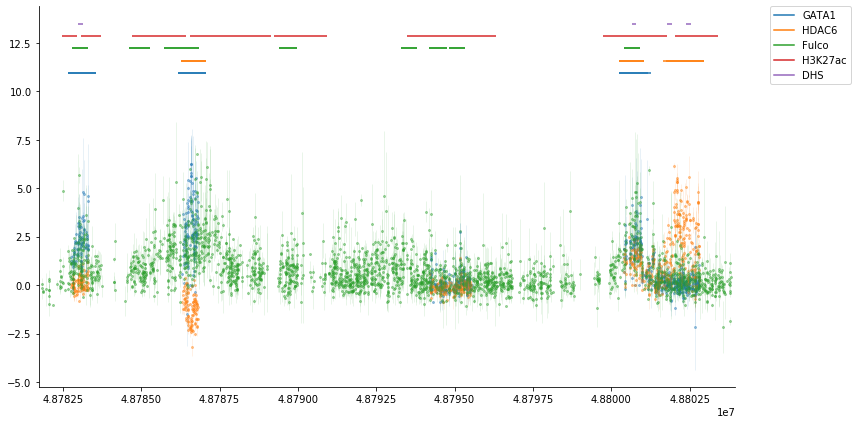

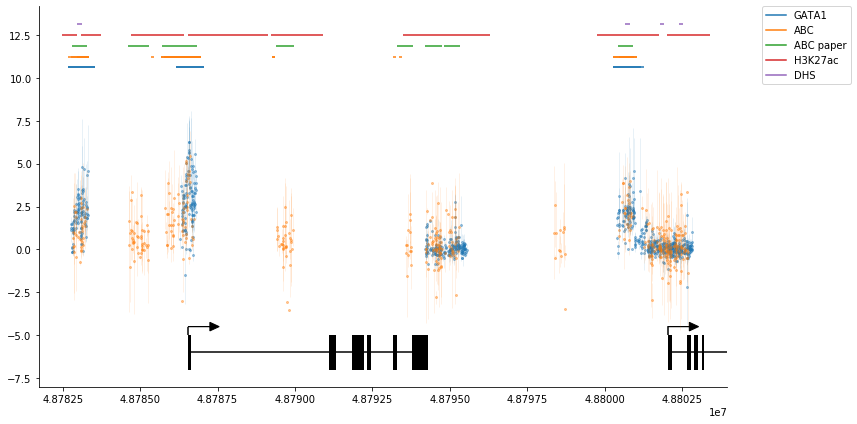

In [20]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48781722,48803966]]), 
                               data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])
fig_h.savefig('GATA_locus__48781722_48803966__all.pdf')
fig_h, ax_h = plot_combined_cutsites(np.array([[48781722,48803966]]), 
                               data, test_peaks, plot_ids=['G1R1','G1R2','ABC1','ABC2','ABC3','Ref2','k27','DHS'])
_draw_genes_from_gff(ax_h, gff, promoter_params=[700,0.5,300])

fig_h.savefig('GATA_locus_with_ABC__48781722_48803966__all.pdf')


GATA1
174
HDAC6
272
Fulco
4


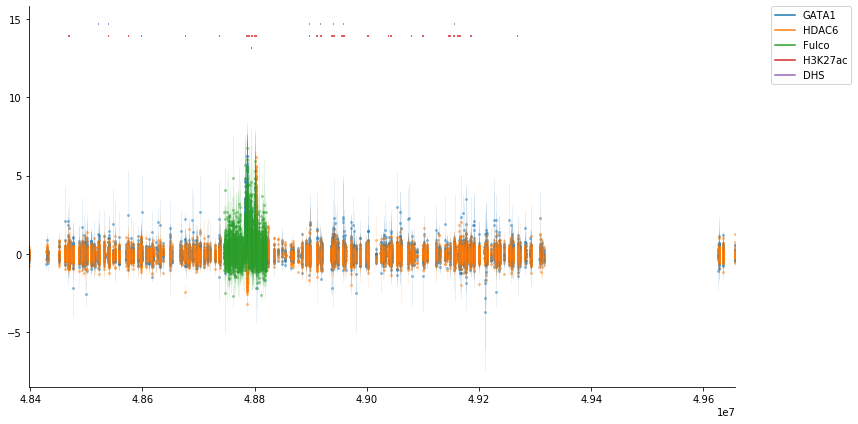

In [21]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48397729,49657309]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])


GATA1
0
HDAC6
1
Fulco
0


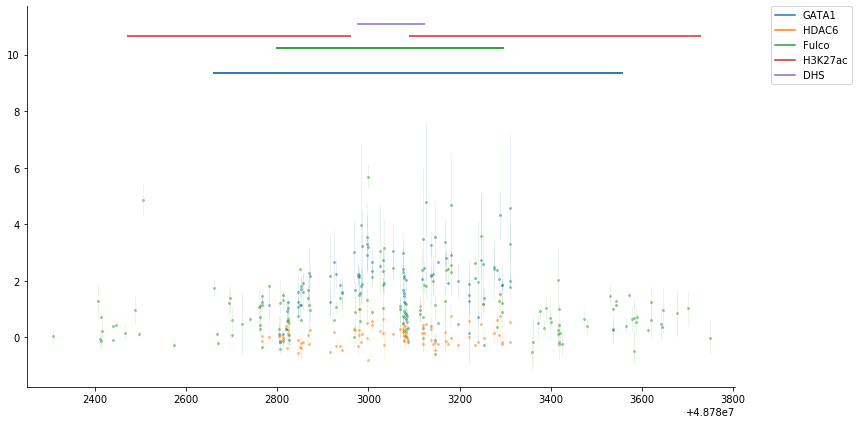

In [22]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48782251,48783805]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])
fig_h.savefig('GATA_locus__48782251_48783805__all.pdf')

GATA1
0
HDAC6
1
Fulco
1


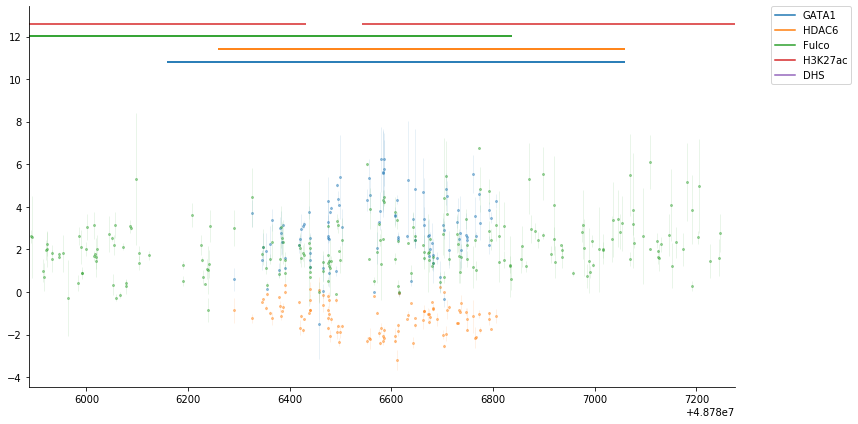

In [23]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48785887,48787277]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])
fig_h.savefig('GATA_locus__48785887_48787277__all.pdf')

GATA1
6
HDAC6
6
Fulco
1


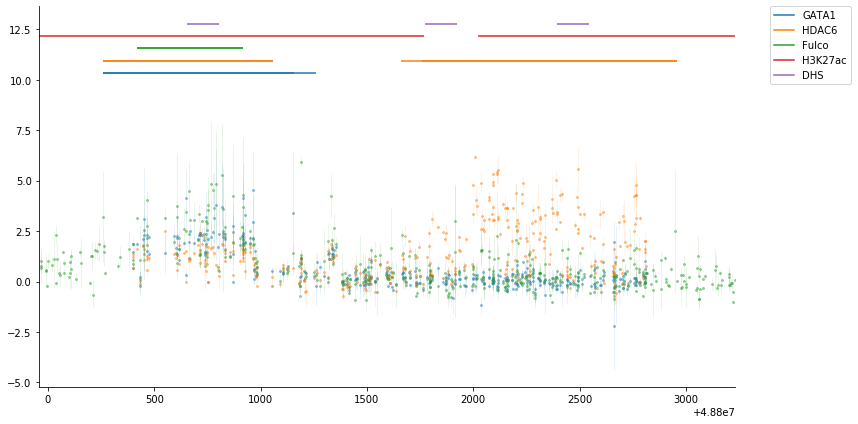

In [24]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48799956,48803233]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])
fig_h.savefig('GATA_locus__48799956_48803233__all.pdf')

GATA1
0
HDAC6
0
Fulco
0
GATA1
0
ABC
3
Fulco
0


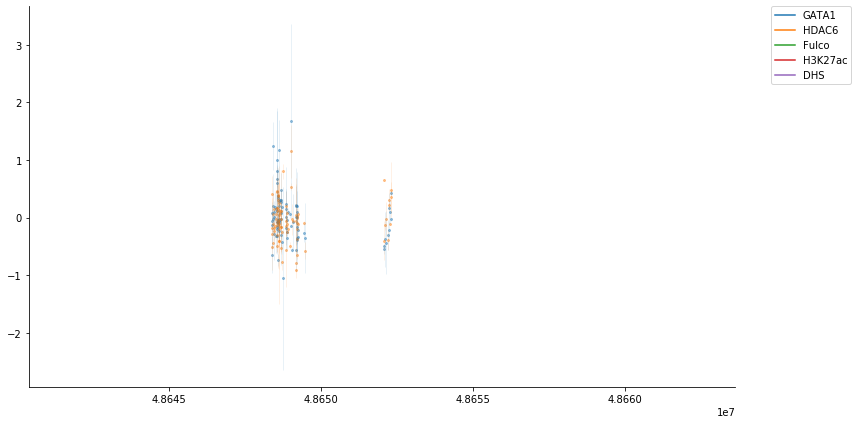

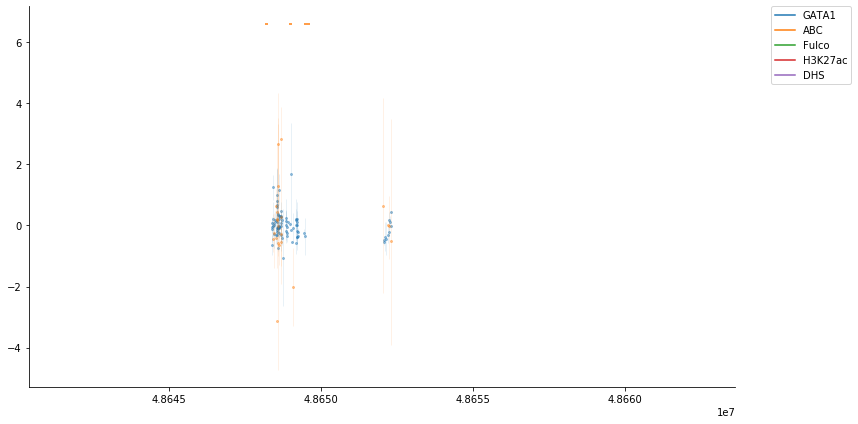

In [25]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48640416,48663623]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])
fig_h.savefig('GATA_locus__48663623_48663623__all.pdf')

fig_h, ax_h = plot_combined_cutsites(np.array([[48640416,48663623]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','ABC1','ABC2','ABC3','FUL1','FUL2','k27','DHS'])


GATA1
0
GATA1
0
ABC
3
Fulco
0


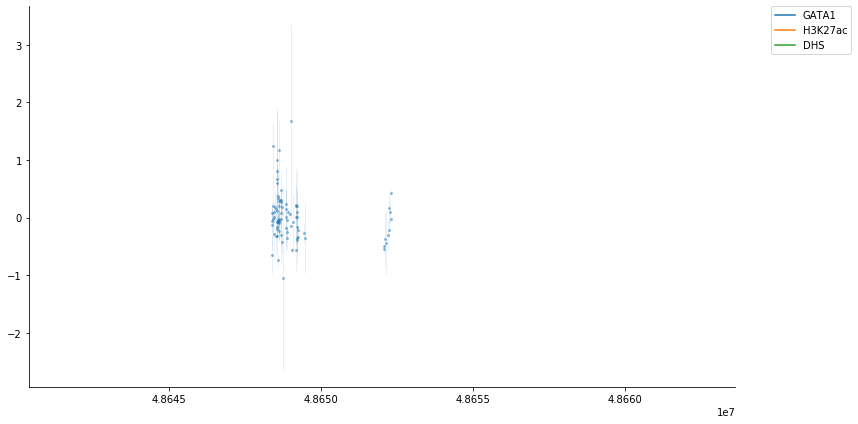

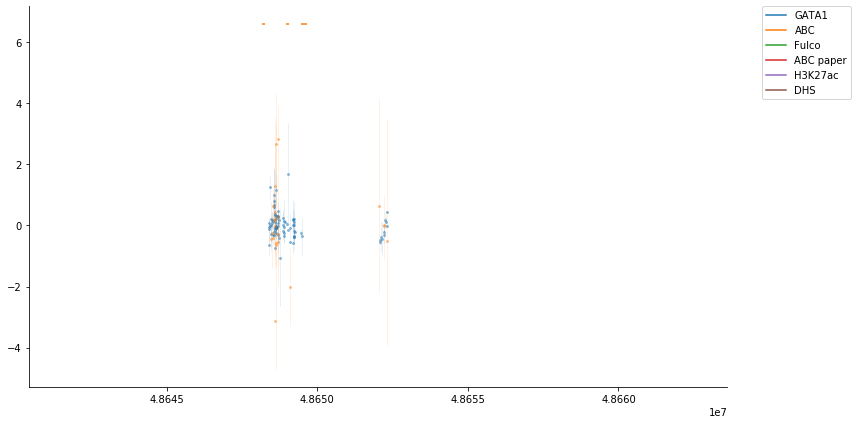

In [26]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48640416,48663623]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','k27','DHS'])
fig_h.savefig('GATA_locus__48663623_48663623__all.pdf')

fig_h, ax_h = plot_combined_cutsites(np.array([[48640416,48663623]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','ABC1','ABC2','ABC3','FUL1','FUL2','Ref2','k27','DHS'])


### Fulco signal track

In [27]:
def merge_intervals(intervals):
    sorted_intervals = intervals[ intervals[:,0].argsort() ]
    merged_intervals = sorted_intervals[0:1]
    for i in range(1,sorted_intervals.shape[0]):
        next_interval = sorted_intervals[i:i+1]
        last_interval = merged_intervals[-1:]
        if next_interval[0,0] <= last_interval[0,1]:
            new_max = max( next_interval[0,1], last_interval[0,1] )
            merged_intervals[-1,1] = new_max
        else:
            merged_intervals = np.concatenate([merged_intervals,next_interval], axis=0)
    return merged_intervals

In [28]:
targ_data = fulc.loc[ fulc.index != 'NT' ]
plus_offsets = [152, 147]
minus_offsets= [146, 153]
pos_array = np.array([ [ int(coord.split(':')[1].split('-')[1]) - plus_offsets[0],
                         int(coord.split(':')[1].split('-')[1]) + plus_offsets[1] ] if coord.split(':')[2] == '+' 
                       else [ int(coord.split(':')[1].split('-')[1]) - minus_offsets[0],
                              int(coord.split(':')[1].split('-')[1]) + minus_offsets[1] ]
                       for coord in targ_data.index ])

In [29]:
merged_pos = merge_intervals(pos_array)

In [30]:
genome_lims = (np.min(pos_array), np.max(pos_array))
print("{}-{}={}".format(genome_lims[1], genome_lims[0], genome_lims[1] - genome_lims[0]))


48821431-48745125=76306


In [31]:
nt_data = np.zeros( shape=[0, 5] )
last_start    = genome_lims[0]
last_subset = targ_data[ (pos_array[:,0] <= last_start) * (pos_array[:,1] > last_start) ]
ep = 1e-200 # epsilon for stability

for i, segment in enumerate( merged_pos ):
    if i == (merged_pos.shape[0]-1):
        segment[1] += 1
    for j, nt_pos in enumerate( range(*segment) ):
        nt_subset = targ_data[ (pos_array[:,0] <= nt_pos) * (pos_array[:,1] > nt_pos) ]
        if not nt_subset.index.equals(last_subset.index):
            score1 = last_subset[ 'FUL1' ].sum()
            score2 = last_subset[ 'FUL2' ].sum()
            new_entry = np.array([[last_start, last_nt+1, last_subset.shape[0], score1, score2]])
            nt_data = np.concatenate([nt_data,new_entry])
            last_start = nt_pos
        last_subset = nt_subset
        last_nt     = nt_pos
    if i % 20 == 0:
        print("On chunk [{}/{}]".format(i,merged_pos.shape[0]))


On chunk [0/38]
On chunk [20/38]


In [32]:
nt_data = pd.DataFrame(nt_data,columns=["start","stop","guide_count","rep1","rep2"])
nt_data[["start","stop","guide_count"]] = nt_data[["start","stop","guide_count"]].astype(np.int64)

In [33]:
nt_data.to_csv("Fulco_screen__score_track.txt", sep="\t", quoting=csv.QUOTE_NONE, index=False)

# Check metadata features

In [34]:
def get_tidy_table(input_df, data_columns):
    new_columns = [ x for x in input_df.columns if x not in data_columns ]
    new_table   = []
    for data_col in data_columns:
        for line in input_df.iterrows():
            new_line = []
            new_line.append(line[1][data_col])
            new_line.append(data_col)
            for new_col in new_columns:
                new_line.append(line[1][new_col])
            new_table.append(new_line)
        print('Finished {}'.format(data_col),file=sys.stderr)
    return pd.DataFrame(new_table, columns=['obs','obs_type']+new_columns)

In [35]:
fulc_full = pd.read_table(FULC_fn, sep='\t', header=0)

fulc_full['Coordinates'] = [ pg_coord if pg_coord != '.' else ga_coord 
                             for pg_coord, ga_coord 
                             in zip(fulc_full['PanGata_coords'], fulc_full['Fulco_CRISPRi_Growth_coords']) ]

fulc_full = fulc_full.set_index('Coordinates')

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [36]:
data_cp = data.copy()
data_cp = data_cp.assign(specificity=pd.to_numeric(fulc_full['cutting specificity score'],errors='coerce'))
data_cp = data_cp.assign(efficiency=pd.to_numeric(fulc_full['cutting efficiency score'],errors='coerce'))

In [37]:
data_cp['specificity'] = data_cp['specificity'].fillna(value=0.0)
#data_cp = data_cp[ ~data_cp['efficiency'].isna() ]

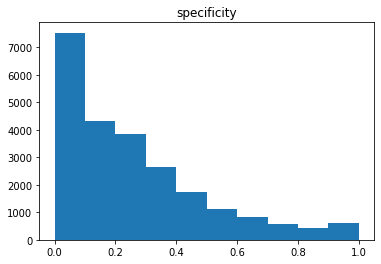

In [38]:
plt.hist(
    data_cp['specificity']
)
plt.title("specificity")
plt.show()

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


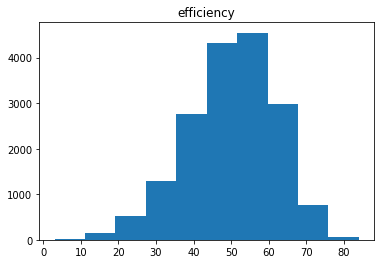

In [39]:
plt.hist(
    data_cp['efficiency']
)
plt.title("efficiency")
plt.show()

In [40]:
spe_bins = np.nanquantile(data_cp[ data_cp['specificity'] > 0.0 ]['specificity'],[0.25,0.5,0.75])
data_cp = data_cp.assign(specificity_bin=np.digitize(data_cp['specificity'],spe_bins))
print(spe_bins)
spe_bins = np.nanquantile(data_cp['efficiency'],[0.25,0.5,0.75])
data_cp = data_cp.assign(efficiency_bin=np.digitize(data_cp['efficiency'],spe_bins))
print(spe_bins)

[0.17146377 0.2766837  0.4505849 ]
[43. 51. 57.]


In [41]:
spe_bins

array([43., 51., 57.])

In [42]:
data_cp = data_cp.reset_index()
data_cp.columns = ['Coordinates']+list(data_cp.columns[1:])

tidy_data = get_tidy_table(data_cp, ['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','ABC1','ABC2','ABC3'])
tidy_data = tidy_data[ ~tidy_data['obs'].isnull() ]

Finished G1R1
Finished G1R2
Finished H6R1
Finished H6R2
Finished FUL1
Finished FUL2
Finished ABC1
Finished ABC2
Finished ABC3


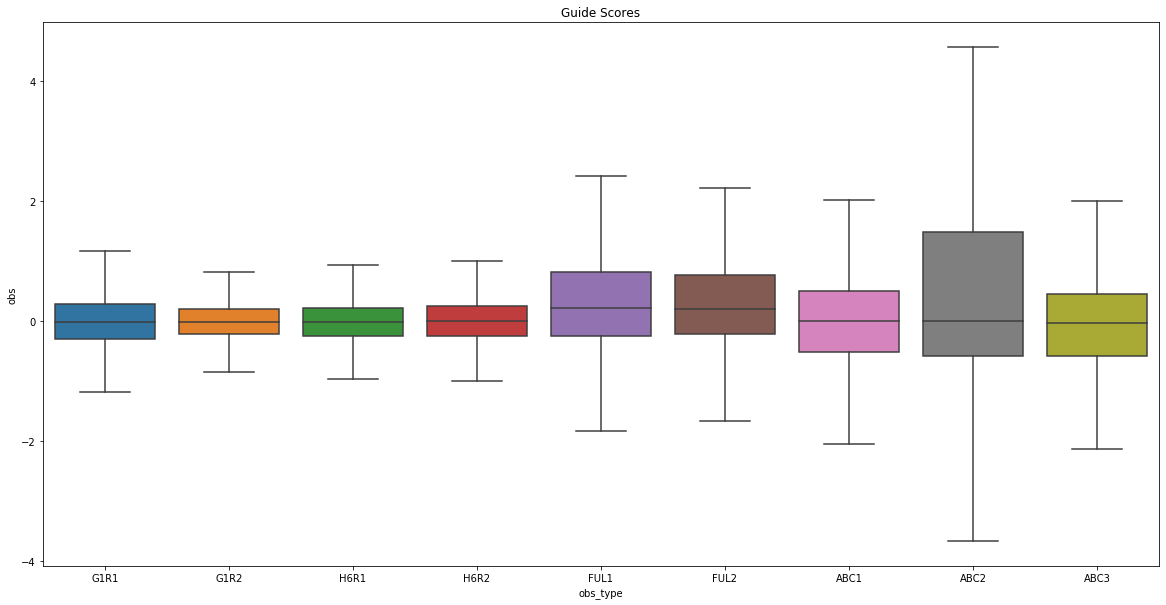

In [43]:
plt.figure(figsize=(20,10))
sns.boxplot(x='obs_type',y='obs',data=tidy_data, showfliers = False) \
  .set_title("Guide Scores");

plt.savefig('marginal_guide_score_distributions.pdf')

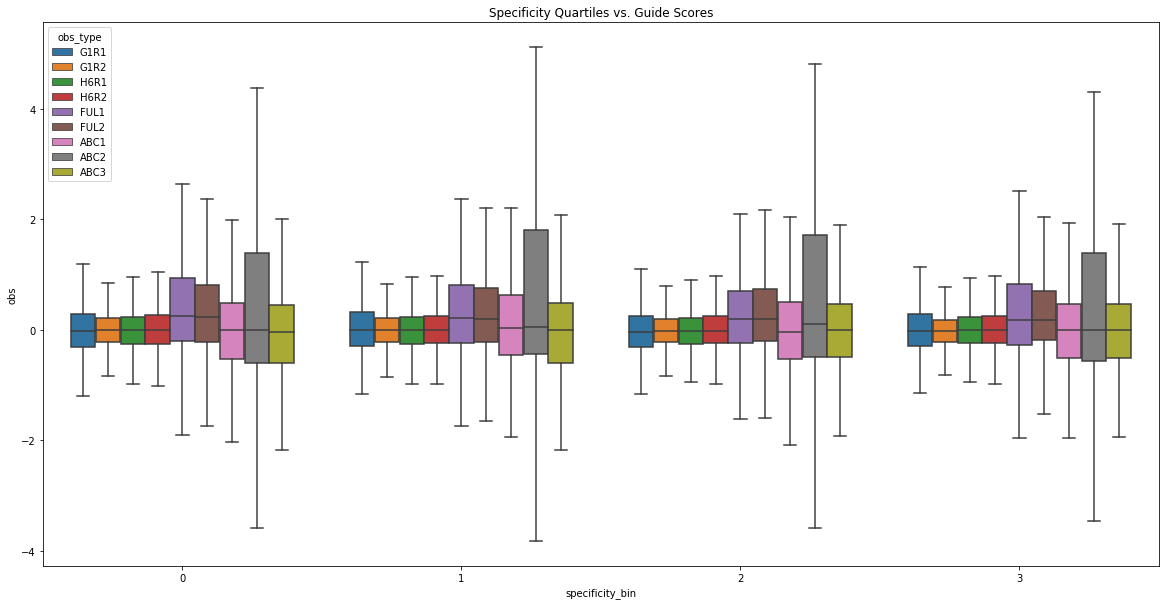

In [44]:
plt.figure(figsize=(20,10))
sns.boxplot(x='specificity_bin',y='obs',hue='obs_type',data=tidy_data, showfliers = False) \
  .set_title("Specificity Quartiles vs. Guide Scores");

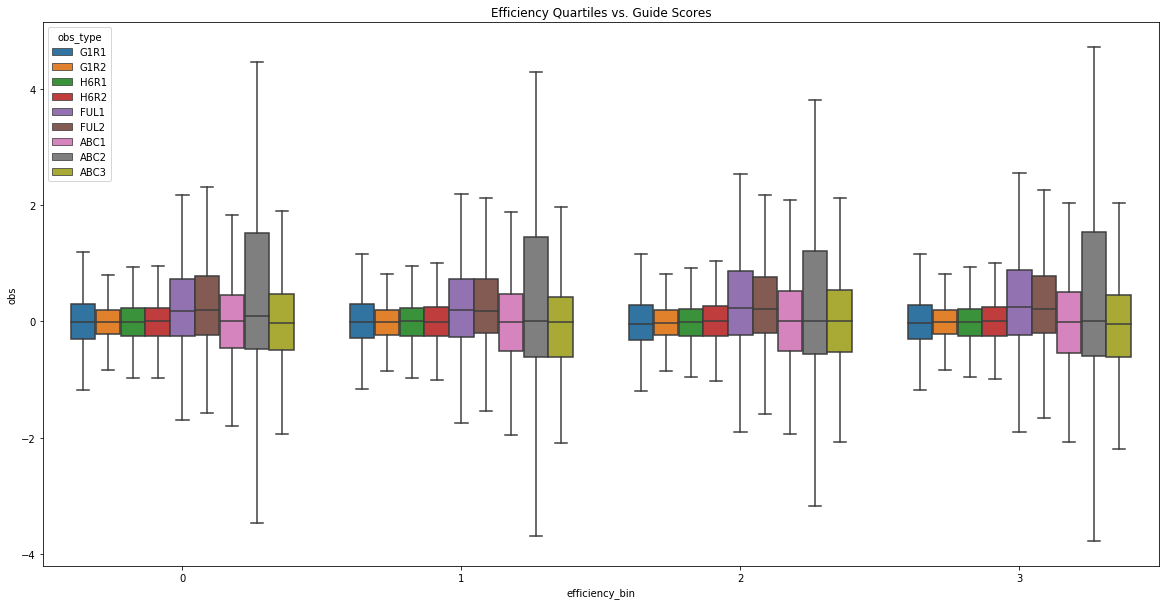

In [45]:
plt.figure(figsize=(20,10))
sns.boxplot(x='efficiency_bin',y='obs',hue='obs_type',data=tidy_data, showfliers = False) \
  .set_title("Efficiency Quartiles vs. Guide Scores");

Text(0.5, 1.0, 'Specificity Quartiles vs. Growth Guide Scores')

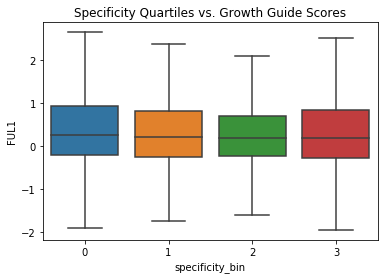

In [46]:
sns.boxplot(x='specificity_bin',y='FUL1',data=data_cp[ ~data_cp['FUL1'].isna() ], showfliers = False) \
   .set_title("Specificity Quartiles vs. Growth Guide Scores")

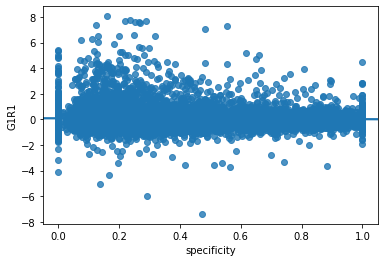

In [47]:
sns.regplot(x='specificity',y='G1R1',data=data_cp[ ~data_cp['G1R1'].isna() ])

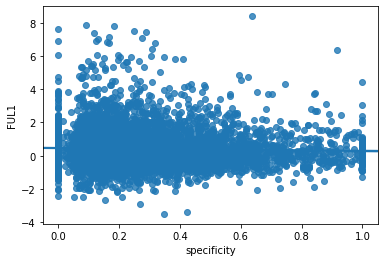

In [48]:
sns.regplot(x='specificity',y='FUL1',data=data_cp[ ~data_cp['FUL1'].isna() ])

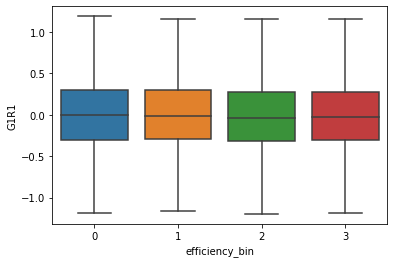

In [49]:
sns.boxplot(x='efficiency_bin',y='G1R1',data=data_cp[ ~data_cp['G1R1'].isna() ], showfliers = False)

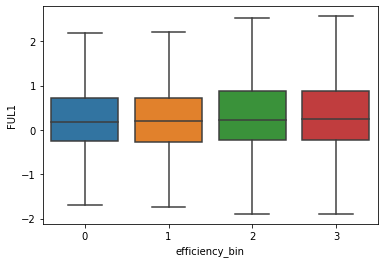

In [50]:
sns.boxplot(x='efficiency_bin',y='FUL1',data=data_cp[ ~data_cp['FUL1'].isna() ], showfliers = False)

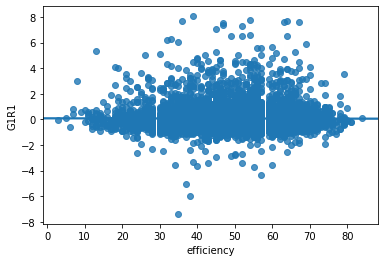

In [51]:
sns.regplot(x='efficiency',y='G1R1',data=data_cp[ ~data_cp['G1R1'].isna() ])

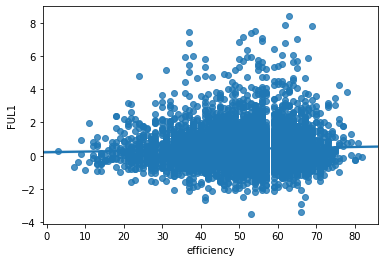

In [52]:
sns.regplot(x='efficiency',y='FUL1',data=data_cp[ ~data_cp['FUL1'].isna() ])

## Filter by Fulco reported Peaks

In [53]:
GATA_filter = pd.read_table('../data/ABC_rep1__sigPeaks.bed',usecols=[0,1,2],names=['chr','start','end'])

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [54]:
tidy_inPeaks = []
for item in tidy_data.iterrows():
    check = sum(check_overlap([item[1]['cutsite'], item[1]['cutsite']+1],
                              GATA_filter.loc[:,('start','end')].values))
    if check > 0:
        tidy_inPeaks.append(item[1])
    if (item[0] + 1) % 50000 == 0:
        print("finished {} rows".format(item[0]+1))

tidy_inPeaks = pd.DataFrame(tidy_inPeaks).reset_index(drop=True)

finished 50000 rows
finished 100000 rows
finished 150000 rows


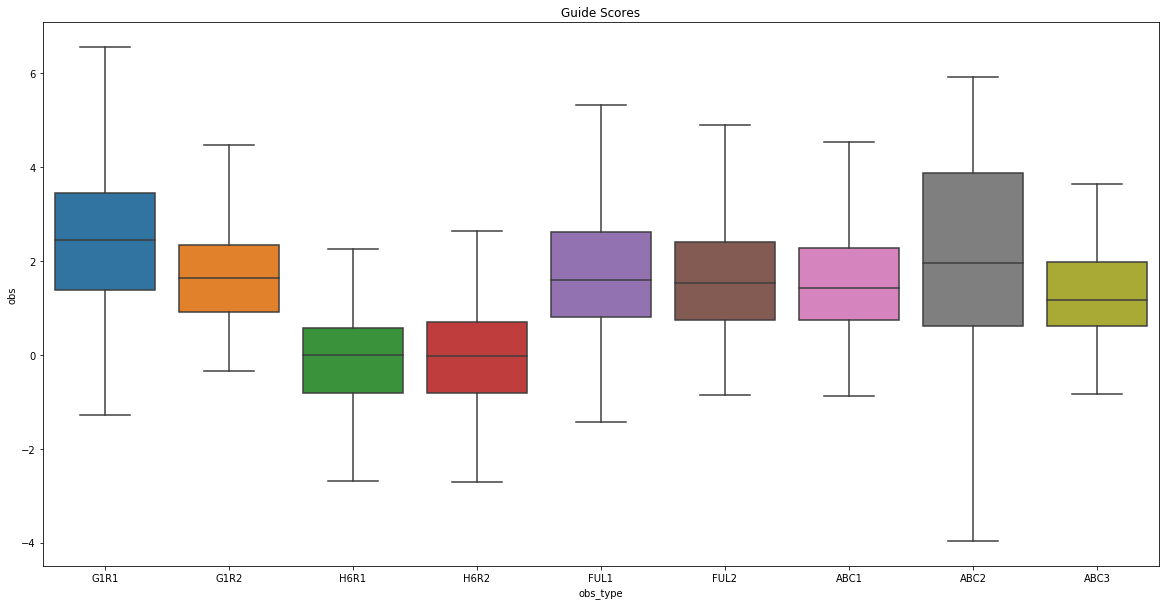

In [55]:
plt.figure(figsize=(20,10))
sns.boxplot(x='obs_type',y='obs',data=tidy_inPeaks, showfliers = False) \
  .set_title("Guide Scores");

plt.savefig('inPeak_guide_score_distributions.pdf')

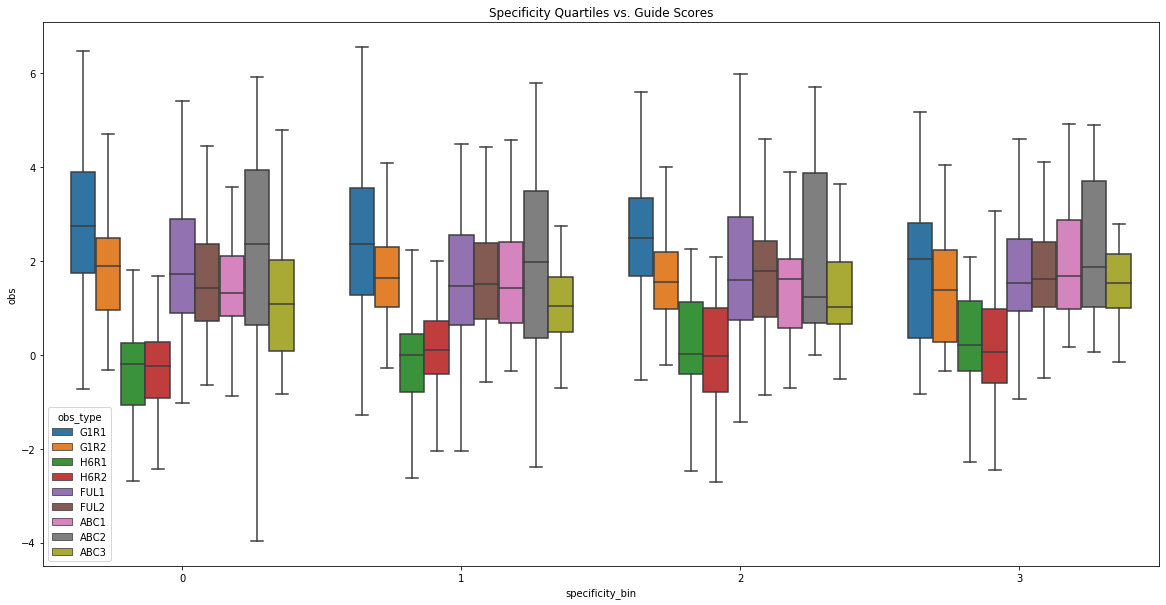

In [56]:
plt.figure(figsize=(20,10))
sns.boxplot(x='specificity_bin',y='obs',hue='obs_type',data=tidy_inPeaks, showfliers = False) \
  .set_title("Specificity Quartiles vs. Guide Scores");

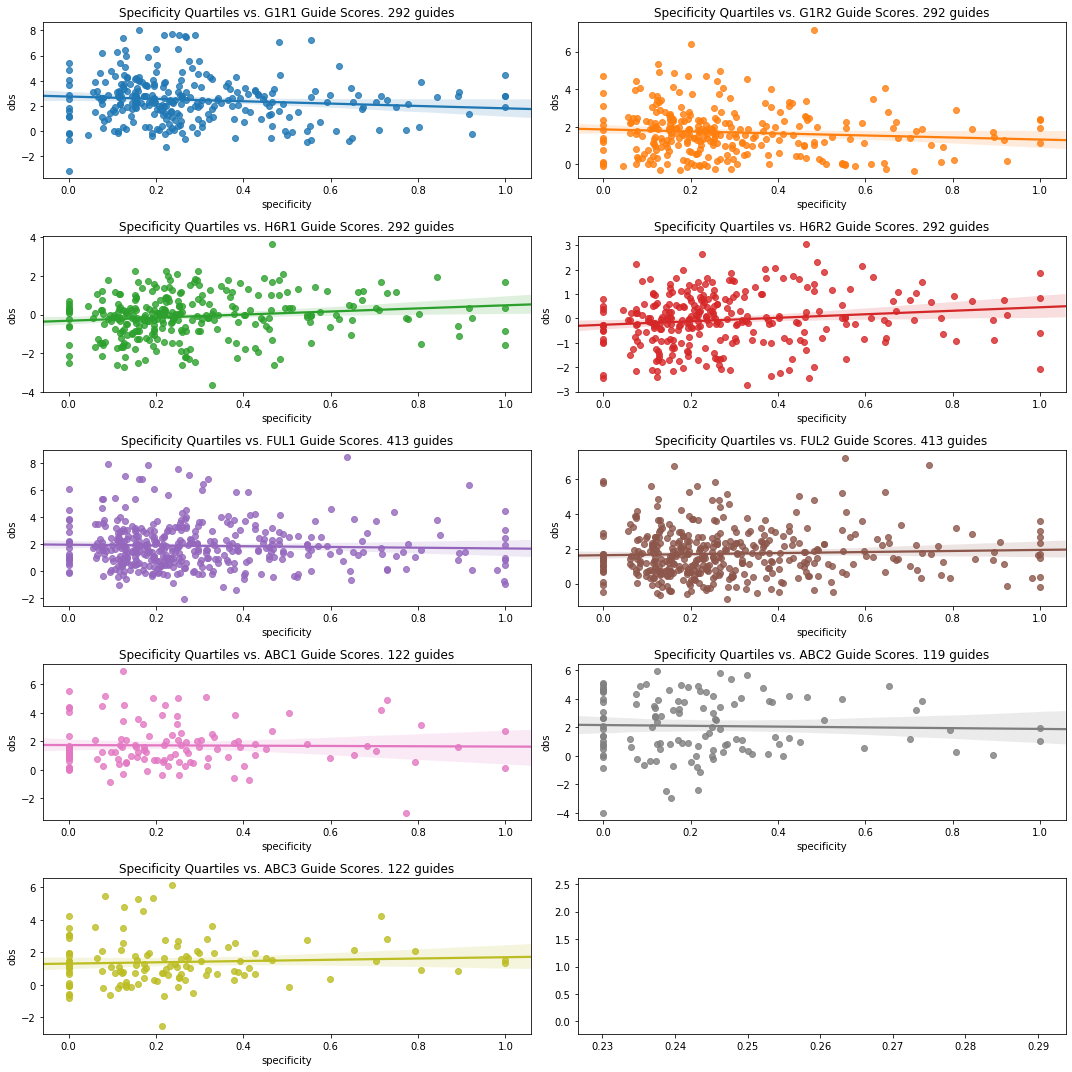

In [57]:
f, axes = plt.subplots(5, 2,figsize=(15,15))
for i,rep_tag in enumerate(['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','ABC1','ABC2','ABC3']):
    guide_ct = tidy_inPeaks[ tidy_inPeaks['obs_type'] == rep_tag ].shape[0]
    sns.regplot(x='specificity',y='obs',
                data=tidy_inPeaks[ tidy_inPeaks['obs_type'] == rep_tag ],ax=axes[i//2,i%2]) \
      .set_title("Specificity Quartiles vs. {} Guide Scores. {} guides".format(rep_tag, guide_ct))

plt.tight_layout()
plt.show()

# Reanalyze raw ABC data

In [58]:
G1R1_fn = '../data/FULCO__GATA1_rep1_10p.txt'

fn_list = [G1R1_fn]

exp_ids = ['G1R1','G1R2']

fullinfo= [("GATA1",1),("GATA1",2)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

In [59]:
abcd = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    abcd.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
abcd = pd.concat([ df.set_index('Coordinates') for df in abcd ],axis=1)

In [61]:
abcd['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in abcd.index ]

In [62]:
test_peaks = [ pd.read_table(fn,sep='\t',header=None,names=['chr','start','end']) for fn in ['../data/FULCO__GATA1_rep1_10p__mergedPeaks.bed','../data/hold.txt'] ]
print(len(test_peaks))
extra_feat = [ pd.read_table(fn,sep='\t',header=None,names=['chr','start','end'],usecols=[0,1,2]) for fn in ['../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed','../data/DNASE_peaks_replicated.bed'] ]
[ test_peaks.append( feat.loc[ feat['chr'] == 'chrX' ,:] ) for feat in extra_feat ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print(len(test_peaks))
for exp_id, peaks_idx in zip(['G1R1','G1R2','k27','DHS'],range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


2
4


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


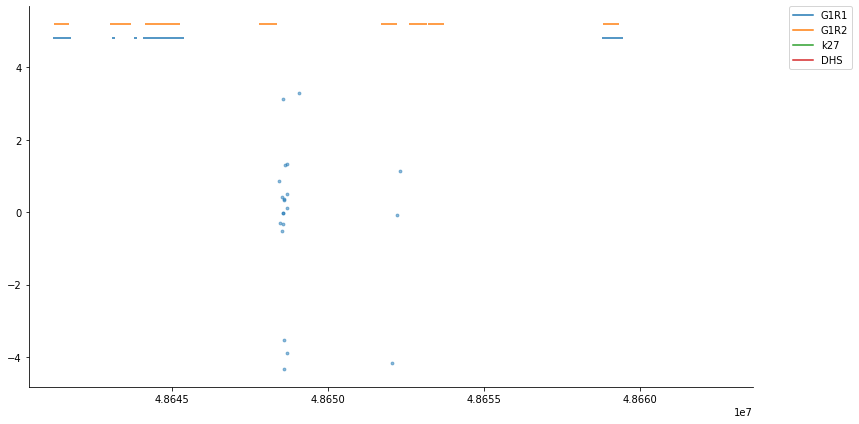

In [63]:
fig_h, ax_h = plot_hff_cutsites(np.array([[48640416,48663623]]), 
          abcd, test_peaks, plot_ids=['G1R1','G1R2','k27','DHS'])
# Here G1R1 is ABC-GATA1-Rep1 analyzed with our method
#  and G1R2 is ABC-GATA1-Rep1 reported significant peaks
#  Note: The non-replicated peaks (i.e. the extra orange ones)
#        are in the GATA1 gene body, I think. Fulco et al. report
#        removing them from analysis due to this fact.